Load the libraries

In [178]:
# Load Library
from google.colab import drive

import time

import random

import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import pandas as pd

seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Mount the drive

In [179]:
drive.mount('/content/drive/')
path = '/content/drive/My Drive/Colab Notebooks/ESC597/Deep Learning/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load the data

In [180]:
time_start = time.time()

filename = 'POROSITY'

xdf1 = np.loadtxt('{}{}_data1.txt'.format(path, filename)) #Time signals usesd as input to the ML
ydf1 = np.loadtxt('{}{}_info1_class.txt'.format(path, filename)) #Category Label vector

xdf2 = np.loadtxt('{}{}_data2.txt'.format(path, filename)) #Time signals usesd as input to the ML
ydf2 = np.loadtxt('{}{}_info2_class.txt'.format(path, filename)) #Category Label vector

xdf = np.concatenate((xdf1, xdf2), axis=0)
ydf = np.concatenate((ydf1, ydf2), axis=0)

time_taken = time.time() - time_start
print('\nTotal time taken loading data (in seconds): {:.2f}'.format(time_taken))


Total time taken loading data (in seconds): 1.05


Split the data into training, validation and testing datsets

In [181]:
X_train, X_test, y_train, y_test = train_test_split(xdf, ydf, test_size = 0.1, random_state = seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.11, random_state = seed, shuffle=True)

print("X_train Size:" + str(X_train.shape))
print("X_val Size:" + str(X_val.shape))
print("X_test Size:" + str(X_test.shape))

print("y_train Size:" + str(y_train.shape))
print("y_val Size:" + str(y_val.shape))
print("y_test Size:" + str(y_test.shape))

X_train Size:(1600, 500)
X_val Size:(198, 500)
X_test Size:(200, 500)
y_train Size:(1600,)
y_val Size:(198,)
y_test Size:(200,)


Normalize the data

In [182]:
scaler = MinMaxScaler((-1, 1))

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Turn output values values to one-hot coding.

In [183]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
print(tf.shape(y_val))

tf.Tensor([198   3], shape=(2,), dtype=int32)


Define class to build the MLP model

In [184]:
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, kernel_std, bias, seed, device):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=kernel_std, seed = seed)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(bias * tf.ones([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=kernel_std, seed = seed))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(bias * tf.ones([1, self.size_hidden2]))

    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=kernel_std, seed = seed))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(bias * tf.ones([1, self.size_hidden3]))

    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=kernel_std, seed = seed))
    # Initialize biases for hidden layer
    self.b4 = tf.Variable(bias * tf.ones([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

 def fit(self, X_train, y_train, X_val, y_val, opti, NUM_EPOCHS, batch_size, seed, plot_loss, verbose):
    if plot_loss == "True":
      self.fig, self.ax = plt.subplots()
      self.fig.set_size_inches(60, 18)
      self.fig.tight_layout(pad = 20)

      scatter_size = 200
      fontsize_axes = 40
      fontsize_ticks = 40
      fontsize_title = 40
      fontsize_legend = 40

    for epoch in range(NUM_EPOCHS):
    # Training and performance on training dataset
      loss_total_train = tf.zeros([1,1], dtype=tf.float32)
        
      train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(batch_size)
      for inputs, outputs  in train_ds:
        preds = self.forward(inputs) 
        loss_total_train = loss_total_train + self.loss(preds, outputs) # Calculation of training loss
        self.backward(inputs, outputs, opti)

      if verbose == 1:
        print('Number of Epoch = {} - Average Cross Entropy Loss for Training Dataset: {} '.format(epoch + 1, np.sum(loss_total_train) / X_train.shape[0]))
      
      # Performance on validation dataset
      preds = self.forward(X_val) 
      loss_total_val = self.loss(preds, y_val) # Calculation of validation loss

      if verbose == 1: 
        print('                    - Average Cross Entropy Loss for Validation Dataset: {} '.format(np.sum(loss_total_val) / X_val.shape[0]))

      if plot_loss == "True":
        self.plot(epoch, NUM_EPOCHS, loss_total_train, loss_total_val, scatter_size, fontsize_axes, fontsize_ticks, fontsize_title, fontsize_legend)

    return np.sum(loss_total_train) / X_train.shape[0], np.sum(loss_total_val) / X_val.shape[0]

 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    data_loss = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return data_loss

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      data_loss = self.loss(predicted, y_train)

      regularizer = (tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2)) \
                   + tf.reduce_sum(tf.square(self.W3)) + tf.reduce_sum(tf.square(self.W4))) / 1.0 # L2 Regularization

      current_loss = data_loss + 0.0 * regularizer
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)

    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    
    # Compute output for porosity
    output = tf.matmul(h3, self.W4) + self.b4
    output = tf.nn.softmax(output)
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

 def accuracy(self, y_pred, y_true):
      correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

      return accuracy.numpy()

 def plot(self, epoch, NUM_EPOCHS, loss_total_train, loss_total_val, scatter_size, fontsize_axes, fontsize_ticks, fontsize_title, fontsize_legend):
      if epoch < NUM_EPOCHS - 1:
        self.ax.scatter(epoch + 1, np.sum(loss_total_train) / X_train.shape[0], s = scatter_size, color = 'blue')
        self.ax.scatter(epoch + 1, np.sum(loss_total_val) / X_val.shape[0], s = scatter_size, color = 'orange')
      else:
        self.ax.scatter(epoch + 1, np.sum(loss_total_train) / X_train.shape[0], s = scatter_size, color = 'blue', label = 'Training')
        self.ax.scatter(epoch + 1, np.sum(loss_total_val) / X_val.shape[0], s = scatter_size, color = 'orange', label = 'Validation')
        self.ax.legend(fontsize = fontsize_legend)
      
      self.ax.set_xlabel('Number of Epochs', labelpad = 6, fontsize = fontsize_axes)
      self.ax.set_ylabel('Loss', labelpad = 6, fontsize = fontsize_axes)
      self.ax.set_title('Total', fontsize = fontsize_title)
      self.ax.tick_params(axis='both', which='major', labelsize = fontsize_ticks)

Define GridSearch function

In [185]:
def GridSearch(X_train, y_train, X_val, y_val, input_shape, output_shape, hidden_layer_vals, kernel_std_vals, bias_vals, learning_rate_vals, batch_size_vals, callback, seed):
  n_iter = len(hidden_layer_vals) * len(kernel_std_vals) * len(bias_vals)  * len(learning_rate_vals) * len(batch_size_vals)
  results = []
  k = 0
  for hidden_layers in hidden_layer_vals:
      for kernel_std in kernel_std_vals:
          for bias in bias_vals:
              for lr in learning_rate_vals:
                  for batch_size in batch_size_vals:

                      print(k + 1," out of ",n_iter)

                      model=MLP(size_input, hidden_layers[0], hidden_layers[1], hidden_layers[2], size_output, kernel_std, bias, seed, device='gpu') # Model is initialized

                      # Model starts training
                      opti = tf.keras.optimizers.Adam(learning_rate = lr)
                      NUM_EPOCHS = 10
                      train_loss, val_loss = model.fit(X_train, y_train, X_val, y_val, opti, NUM_EPOCHS, batch_size, seed, plot_loss = "True", verbose = 1)

                      result = []
                      for h in hidden_layers:
                          result.append(h)
                      
                      result = result + [kernel_std, bias, lr, batch_size, train_loss, val_loss]
                      results.append(result)

                      k = k + 1
                          
  return results

Selection of best parameters through GridSearch

1  out of  1
Number of Epoch = 1 - Average Cross Entropy Loss for Training Dataset: 0.03248037815093994 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004958436946676235 
Number of Epoch = 2 - Average Cross Entropy Loss for Training Dataset: 0.02988147974014282 
                    - Average Cross Entropy Loss for Validation Dataset: 0.00490448721731552 
Number of Epoch = 3 - Average Cross Entropy Loss for Training Dataset: 0.02950829029083252 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004894193976816505 
Number of Epoch = 4 - Average Cross Entropy Loss for Training Dataset: 0.029371867179870604 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004705675924667204 
Number of Epoch = 5 - Average Cross Entropy Loss for Training Dataset: 0.028739423751831056 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004724662412296642 
Number of Epoch = 6 - Average Cross Entropy Loss fo

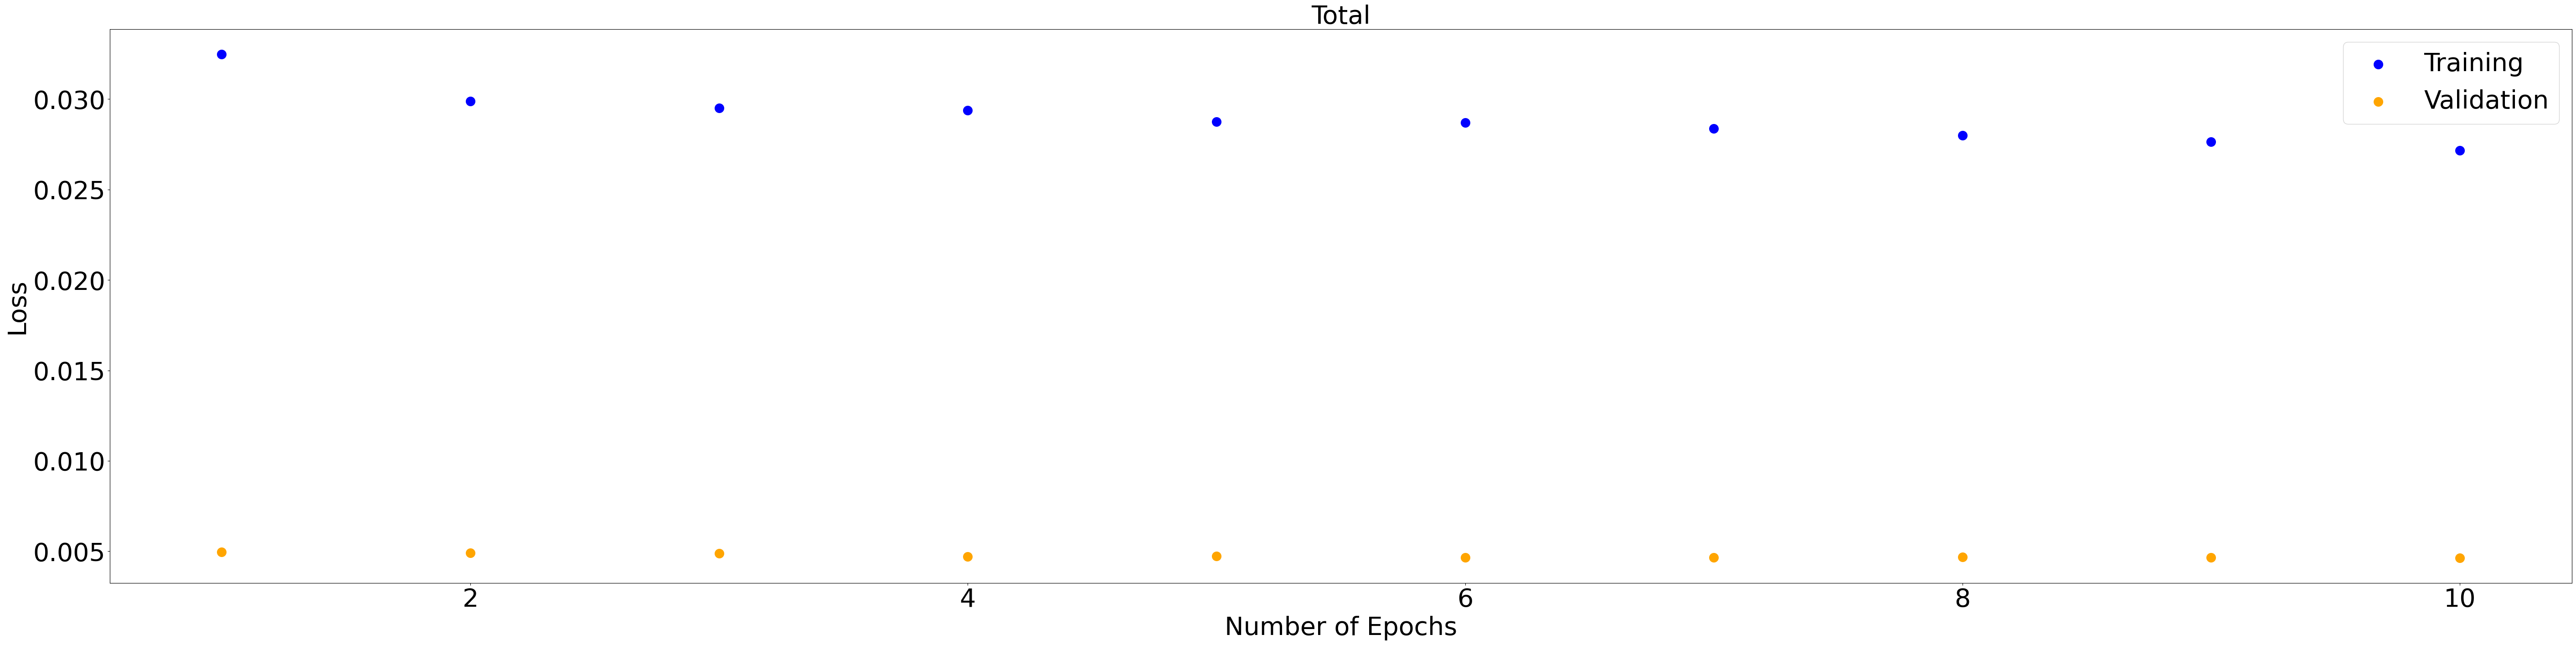

In [186]:
# Define ranges for the architecture of the MLP model
size_input = X_train.shape[1]

size_output = 3

# Hidden layer 1
hidden_layer_1 = [700, ]  # List of values for the hidden units of layer 1 that you want to try.

# Hidden layer 2
hidden_layer_2 = [500, ]  # List of values for the hidden units of layer 2 that you want to try. #(I tried 100, 200, 300, 500, 700)

# Hidden layer 3
hidden_layer_3 = [10, ]  # List of values for the hidden units of layer 3 that you want to try.

# Combination of all parameters for the architecture of hidden layers
hidden_layer_vals = np.array(np.meshgrid(hidden_layer_1, hidden_layer_2, hidden_layer_3)).T.reshape(-1, 3) # List whose each list contains a list with the values for each hidden layer for a given combination of the given parameters

kernel_std_vals = [1e-2, ] # Set the different values you want to try for the standard deviation of the normal distribution used for weight initialization. Try values between 1e-3 and 1.#(I tried 1e-1, 1e-2, 1e-3, 1e-4)

bias_vals = [1e-4,] # Set the different values you want to try for the bias initialization. Try . different orders of magnitude from 1e-5 to 0. #(I tried 1e-2, 1e-4, 1e-6, 0)

output_activation_vals = ["linear", ] # Set the different activation functions you want to try for the output layers.Try "linear", "sigmoid", "relu".
#

# Define ranges for the hyperparameters durign training
learning_rate_vals = [1e-3, ] # Set the different values you want to try for the learning rate. Try different orders of magnitude from 1e-2 to 1e-6. #(I tried 1e-2, 1e-3, 1e-4, 1e-5)

batch_size_vals = [32, ] # Set the different values you want to try for the batch size. Try values between 16 and 64. If you want you can also try 8 or 128 too.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
#

# Perform GridSearch
time_start = time.time()

results = GridSearch(X_train, y_train, X_val, y_val, size_input, size_output, hidden_layer_vals, kernel_std_vals, bias_vals, learning_rate_vals, batch_size_vals, callback, seed)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Output GridSearch results

   Hidden layer1  Hidden layer2  Hidden layer3  Kernel std    Bias  \
0            700            500             10        0.01  0.0001   

   Learning rate  Batch size  Train loss  Validation loss  
0          0.001          32    0.027155         0.004638  


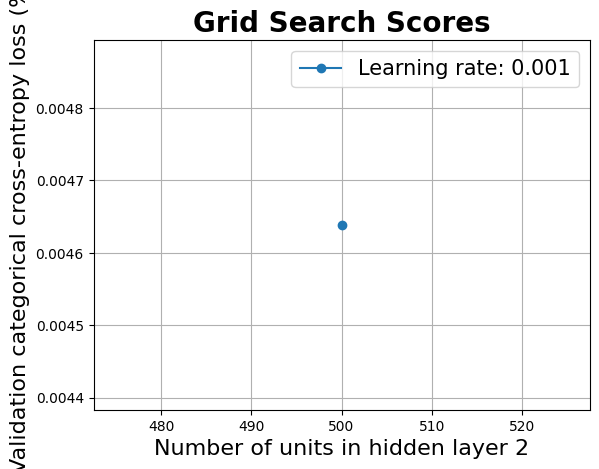

In [187]:
#Print the parameters
column_names = ["Hidden layer1", "Hidden layer2", "Hidden layer3", "Kernel std", "Bias", "Learning rate", "Batch size", "Train loss", "Validation loss"]
df = pd.DataFrame (results, columns = column_names)
print(df)

#Plot the parameters
name_param_1 = "Number of units in hidden layer 2"
name_param_2 = "Learning rate"

grid_param_1 = []
for i in range(len(results)):
    grid_param_1.append(results[i][1])

grid_param_1 = np.array(grid_param_1)

grid_param_2 = []
for i in range(len(results)):
    grid_param_2.append(results[i][5])

grid_param_2 = np.array(grid_param_2)

scores = []
for i in range(len(results)):
    scores.append(results[i][-1])

scores = np.array(scores)

# Plot Grid search scores
_, ax = plt.subplots(1,1)

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)

vals = learning_rate_vals
for i in range(len(vals)):
    index = np.where(np.array(grid_param_2) == vals[i])[0]
    ax.plot(grid_param_1[index], scores[index], '-o', label = name_param_2 + ': ' + str(vals[i]))

ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel(name_param_1, fontsize=16)
ax.set_ylabel('Validation categorical cross-entropy loss (%)', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

plt.savefig("convergence")

Print the best parameters based on GridSearch results for minium validation loss (Look that if you want to get the model that generalizes the most)

In [191]:
index = np.where(np.array(results)[:, -1] == min(np.array(results)[:, -1]))[0][0]
print("The minimum validation loss is ", results[index][-1])

best_hidden_layer_1 = results[index][0]
best_hidden_layer_2 = results[index][1]
best_hidden_layer_3 = results[index][2]
best_kernel_std = results[index][3]
best_bias = results[index][4]
best_learning_rate = results[index][5]
best_batch_size = results[index][6]


print("The optimal number of hidden units for hidden layer 1 is ", best_hidden_layer_1)
print("The optimal number of hidden units for hidden layer 2 is ", best_hidden_layer_2)
print("The optimal number of hidden units for hidden layer 3 is ", best_hidden_layer_3)
print("The optimal std for the weight initialization is ", best_kernel_std)
print("The optimal bias value is ", best_bias)
print("The optimal learning rate size is ", best_learning_rate)
print("The optimal batch size is ", best_batch_size)

The minimum validation loss is  0.004638474095951427
The optimal number of hidden units for hidden layer 1 is  700
The optimal number of hidden units for hidden layer 2 is  500
The optimal number of hidden units for hidden layer 3 is  10
The optimal std for the weight initialization is  0.01
The optimal bias value is  0.0001
The optimal output activation function is  0.001
The optimal learning rate size is  0.001
The optimal batch size is  32


Initialize the model using the best parameters based on GridSearch

In [192]:
best_hidden_layers = [best_hidden_layer_1, best_hidden_layer_2, best_hidden_layer_3]

model=MLP(size_input, best_hidden_layers[0], best_hidden_layers[1], best_hidden_layers[2], size_output, best_kernel_std, best_bias, seed, device='gpu')                

Train the model

Number of Epoch = 1 - Average Cross Entropy Loss for Training Dataset: 0.03186204671859741 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004929495881302188 
Number of Epoch = 2 - Average Cross Entropy Loss for Training Dataset: 0.029589648246765136 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004969736542364564 
Number of Epoch = 3 - Average Cross Entropy Loss for Training Dataset: 0.02961207628250122 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004802919397450456 
Number of Epoch = 4 - Average Cross Entropy Loss for Training Dataset: 0.02913025617599487 
                    - Average Cross Entropy Loss for Validation Dataset: 0.00476869609620836 
Number of Epoch = 5 - Average Cross Entropy Loss for Training Dataset: 0.028781273365020753 
                    - Average Cross Entropy Loss for Validation Dataset: 0.004735757606198089 
Number of Epoch = 6 - Average Cross Entropy Loss for Training Da

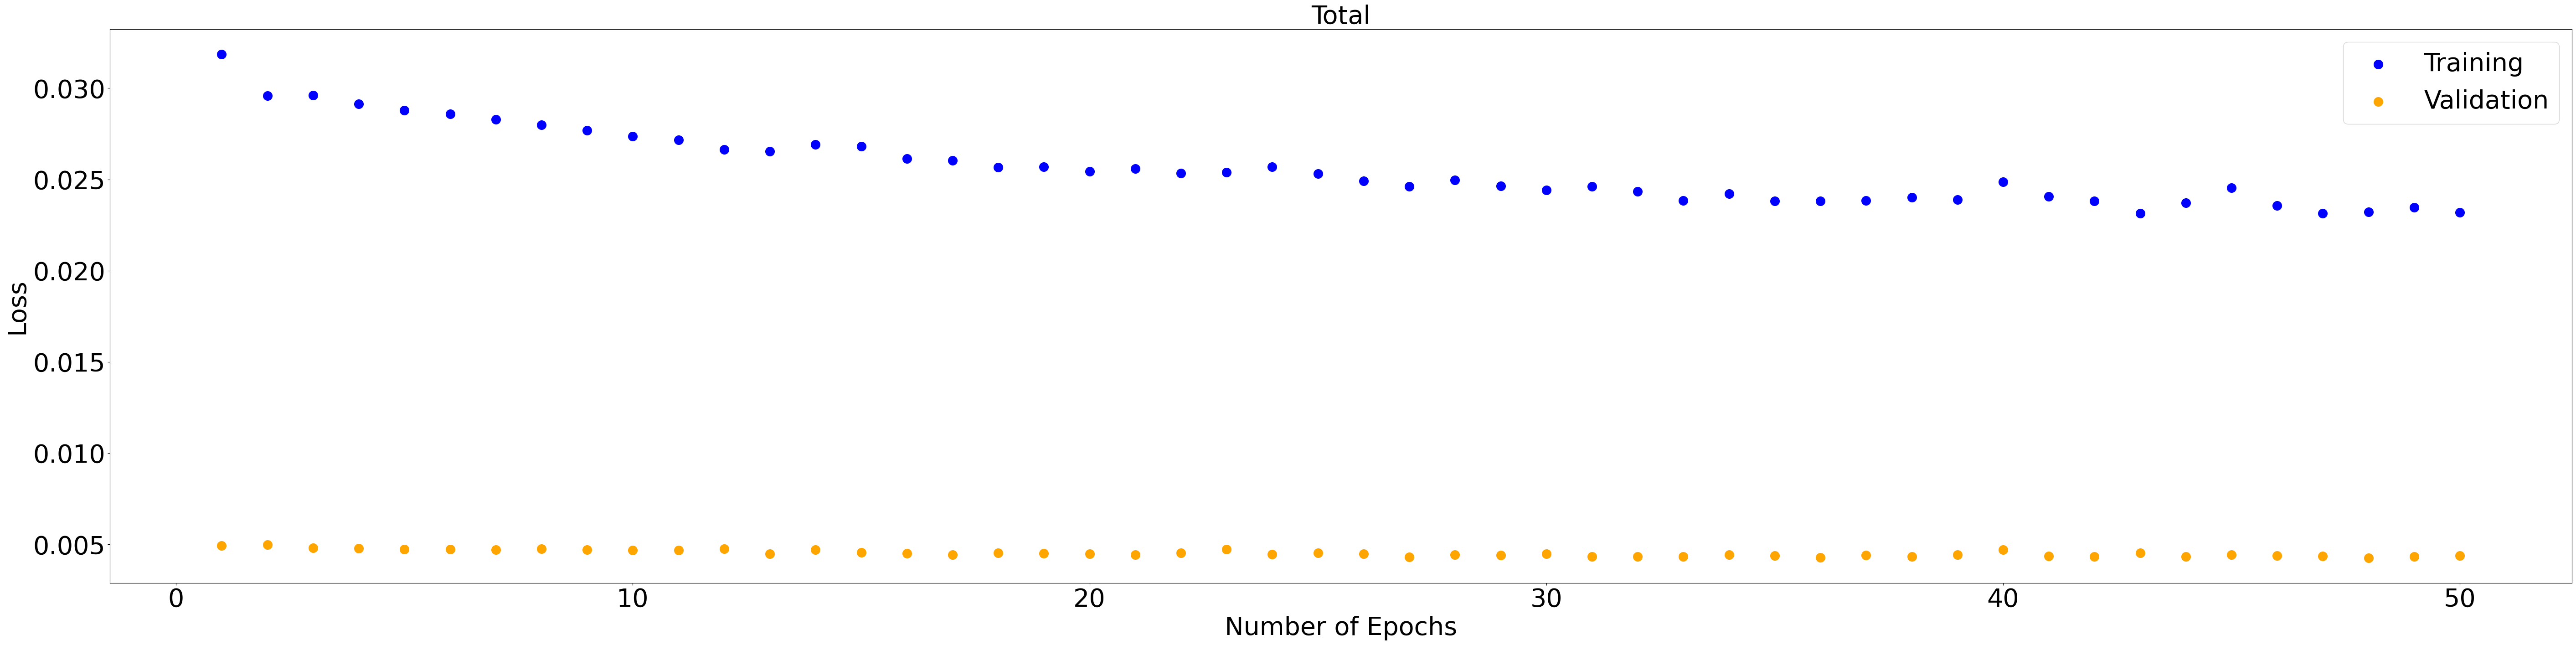

In [ ]:
# Fit model
time_start = time.time()

NUM_EPOCHS = 50 # Set the number of epochs for training
opti = tf.keras.optimizers.Adam(learning_rate = best_learning_rate) # Set the optimizer
batch_size = best_batch_size# Set the batch size during training
train_loss, val_loss = model.fit(X_train, y_train, X_val, y_val, opti, NUM_EPOCHS, batch_size, seed, plot_loss = "True", verbose = 1)
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Make final predictions on training, validation and test datasets

In [ ]:
preds_train = model.forward(X_train)
preds_val = model.forward(X_val) 
preds_test = model.forward(X_test)

Calculation of accuracy for training, validation and testing datasets

In [ ]:
acc_train = model.accuracy(preds_train, y_train)
acc_val = model.accuracy(preds_val, y_val)
acc_test = model.accuracy(preds_test, y_test)

print('\nTrain Accuracy: {:.2f} %'.format(acc_train * 100))
print('\nValidation Accuracy: {:.2f} %'.format(acc_val * 100))
print('\nTesting Accuracy: {:.2f} %'.format(acc_test * 100))


Train Accuracy: 81.31 %

Validation Accuracy: 67.68 %

Testing Accuracy: 83.50 %


DEFINE FUNCTION TO PLOT THE CONFUSION MATRIX

In [ ]:
def plot_confusion_matrix(dataset_type, predicted_labels, true_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title(dataset_type)

    fig=disp.figure_
    fig.set_size_inches(6, 6)
    fig.savefig('Confusion Matrix'+dataset_type+'.jpg', dpi=400)

Creation of Confusion Matrix

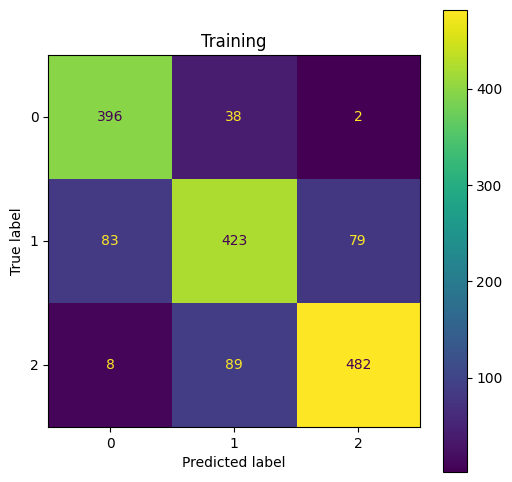

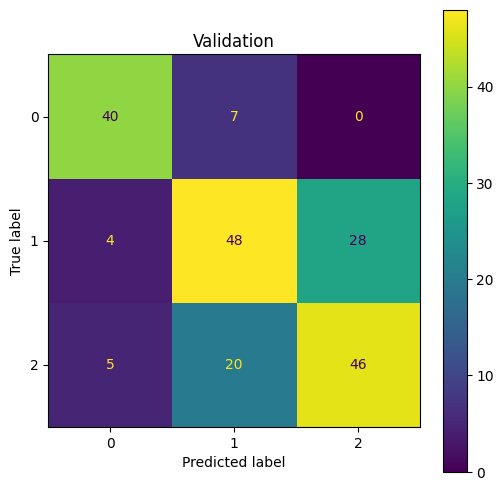

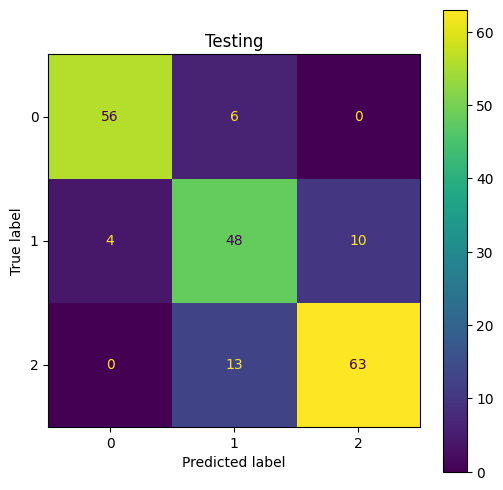

In [ ]:
# Training
dataset_type = "Training"
plot_confusion_matrix(dataset_type, tf.argmax(preds_train, axis = 1), tf.argmax(y_train, axis = 1))

# Validation
dataset_type = "Validation"
plot_confusion_matrix(dataset_type, tf.argmax(preds_val, axis = 1), tf.argmax(y_val, axis = 1))

# Testing
dataset_type = "Testing"
plot_confusion_matrix(dataset_type, tf.argmax(preds_test, axis = 1), tf.argmax(y_test, axis = 1))